# 2025-03-03 Transients ctd. and stiffness

* Since I'm away this week, you'll have to read through these notes on your own.

* They contain **Questions** and **Exercises** for you to do, which we'll discuss next week (03/10)

* Please attempt them, and update your portfolio with questions + any cool answers/plots you made.

## Last time

* Intro to ODEs
* Test problems
* Forward Euler
* Stability diagrams

## Today

* Exploring the $\theta$ method
* PDE as ODE
* Blasius activity

In [88]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

plot_stability (generic function with 1 method)

# Midpoint/trapezoid and $\theta$ methods

* Forward and backward Euler are bookends of the family known as $\theta$ methods.

* If we define an ODE as 
$$u' = f(t, u), \quad t \in [0, T], \quad u(0)\text{ given},$$

and denote the numerical solution as $\tilde{u}$, then $\theta$-methods forecast the solution at a time $h$ later as

$$ \tilde u(h) = u(0) + h f\Big(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \Big) $$

* for linear problems ($u' = Au$), this is solved as

$$ (I - h \theta A) \tilde{u}(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

**Show this yourself!**

* $\theta=0$ is explicit (forward) Euler
* $\theta=1$ is implicit (backward) Euler, and
* $\theta=1/2$ are the midpoint or trapezoid rules (equivalent for linear problems).
* **Question**: What is the stability function $R(z)$ as a function of $\theta$? 

```{toggle}
$$ R(z) = \frac{1 + (1-\theta)z}{1 - \theta z}. $$
```

**Exercise**: Open these notes in a notebook (see instructions [here](https://cu-numpde.github.io/spring25/slides.html), and run the code up till here (you'll need to run the first few code cells too). Play around with the `theta` parameter and observe how the stability region changes. Which color corresponds to stability? For what values of $\theta$ does the stability region remain bounded?

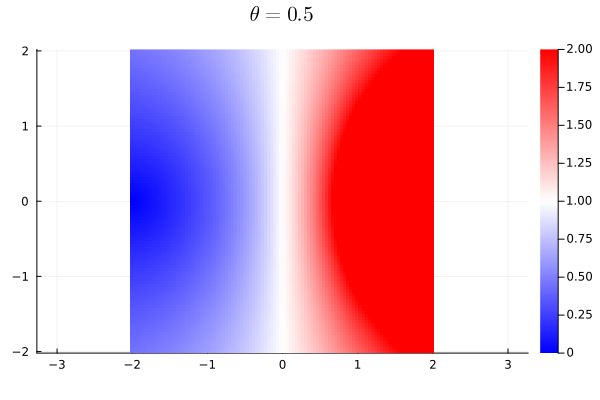

In [149]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta=0.5
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$")

# A $\theta$ solver

* The code below implements a simple ODE solver for problems of the form $u' = Au$ (with $A$ a constant matrix)
* It has a parameter $\theta$, which has a default value of 0.5
* We test it on the oscillatory equation from the last lecture

In [13]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

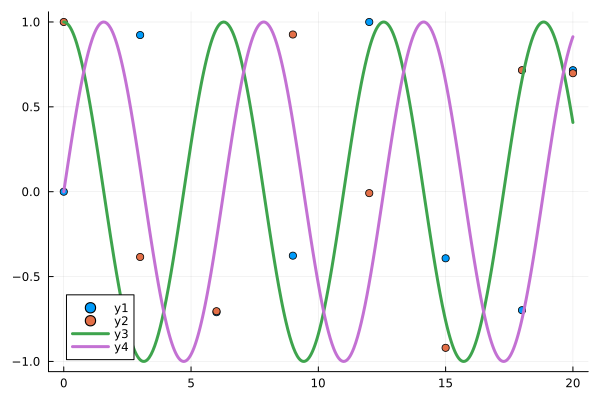

In [32]:
# Test on oscillator
A = [0 1; -1 0]
thist, uhist = ode_theta_linear(A, [0., 1], h=3, theta=0.5, tfinal=20)
scatter(thist, uhist') # Numerical solution for u -- orange discs should track green curve, blue ones should track the purple curve.
plot!([cos, sin])

**Exercises**:

1. Solve the ODE analytically (you can find some hints in the code above). The ODE is 

$$ u' = \underbrace{\begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}}_{A} u. $$

2. Play around with the `h`, `theta`, and `tfinal` arguments in the call for `ode_theta_linear` function above. What values of `theta` does the solution remain bounded for? What value of `h` do you need to get reasonable (by eye) accuracy? 

3. Revisit the stability region of the method corresponding to the value of `theta` that you found leaves the solution bounded. 

* What point(s) in the complex $z$-plane does this ODE and `h`-pair correspond to? You might want to check $\lambda$ for this equation from last week's lecture notes (or compute it yourself), and use $z = \lambda h.$
* For what value of `theta` does the stability region encompass the point(s) from above? 
* Does this agree with your answer to question 2?  
* Based on this, does the choice of `h` matter for the boundedness of the solution for this particular ODE?

# Stiff decay to cosine

* Consider the forced ODE from the last lecture,
$$\dot u = -k(u - \cos t) = -k u + k \cos t.$$
* The code below uses the `ode_theta_linear` method to solve it for $k = 300$.

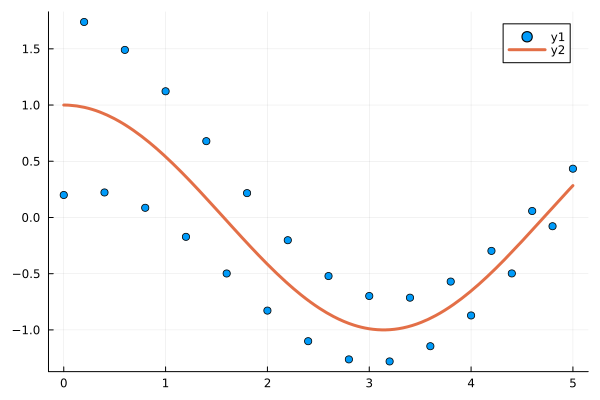

In [109]:
k = 300
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.2, theta=0.5)
scatter(thist, uhist[1,:])
plot!(cos)

**Exercises**:

* Consider just the _transient_ part of the solution. What is $\lambda$ for that ODE? 
* What is $z = \lambda h $ for $h = 0.2$? Plot it over the stability region plot from earlier in this notebook with the `scatter!(x, y)` command. Note that `x`, `y` have to be arrays (e.g. `x = [0.1]`).
* Play around with the `theta` parameter in that stability plot until the point you plotted above lies just outside the stability region. 
* Re-run the code in the previous cell with `theta` set to the just-unstable value you found. What does the numerical solution do at late times (larger `tfinal`)?
* Play around with values of `theta` and observe the stability of the solution.


* The solution above is a mixture of two: the _transient_ and the _steady state_.
* The transient solution goes like $e^{-kt}$, whereas the steady state is roughly $\cos(t)$.
* **Question**: what are the characteristic timescales associated with these solutions? A characteristic timescale is a value $T$ over which a function varies. E.g. for a decaying function, it could be the $T$ after which the function has changed values by a unit factor relative to itself. For an oscillatory one, it could be the period. 

```{toggle}
* One can estimate the characteristic timescale as

$$ T = \left|\frac{f}{f'}\right|, $$
where $f$ is the function in question. 
* So for $e^{-kt}$, it is $k$, and for $\cos(t)$ it is $2 \pi$ (although $\mathbb{1}$ is also acceptable).
```

* In this numerical solution, there is a mixture of two timescales that are extremely different from each other. 
* This, particularly the quickly decaying transient with a large negative $\lambda$ causes ["stiffness"](https://en.wikipedia.org/wiki/Stiff_equation)
* Stiffness doesn't have a clear-cut definition in terms of properties of the ODE, except that 
```
It forces certain numerical methods to choose a stepsize that is excessively smaller than what the smoothness of the analytic solution would suggest.
```
* **Exercise**: Check out the wikipedia article linked to above.

* **Question**: For forward Euler, what `h` would make the solution to the ODE stable? 

```{toggle}
Less than around $2/300 = 0.0066\ldots$.
```

# Advection as linear ODE

* Let's revisit the advection equation, $u_t = -(w u)_x$, with "wind" $w = 1$ and a domain for $x$ that wraps around itself (like a circle). 
* The code below returns $-u_x$, which can be interpreted as $f$ in $u' = f(t, u)$, for a vector $u$.
* We start from an initial "blob" of $u$ shaped like a Gaussian: $u(t = 0, x) = e^{-9x^2}$.
* We then solve the time-dependent part of the PDE as an ODE with out $\theta$-method and plot $u(t, x)$ as a function of $x$ for different values of $t$.
* We also query the eigenvalues of $f$ (i.e. the $\lambda$-s), to check whether they lie in the stability region.

In [145]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
eigvals(Matrix(advect_matrix(10, upwind=true)))

10-element Vector{ComplexF64}:
       -9.99999999999999 + 0.0im
      -9.045084971874736 - 2.93892626146237im
      -9.045084971874736 + 2.93892626146237im
      -6.545084971874738 - 4.7552825814757735im
      -6.545084971874738 + 4.7552825814757735im
       -3.45491502812527 - 4.755282581475771im
       -3.45491502812527 + 4.755282581475771im
     -0.9549150281252627 - 2.9389262614623646im
     -0.9549150281252627 + 2.9389262614623646im
 -1.1781118276566757e-15 + 0.0im

  0.007011 seconds (12.99 k allocations: 8.993 MiB, 25.48% gc time)


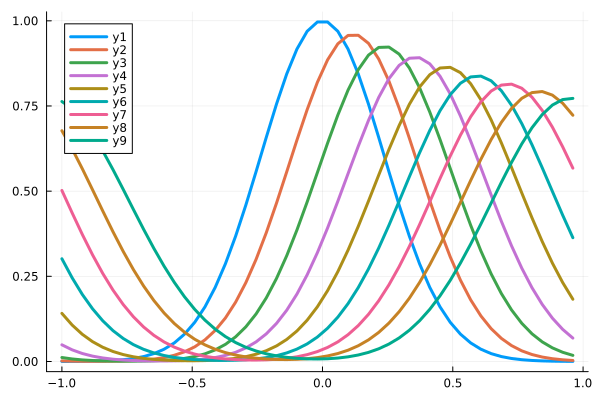

In [194]:
n = 51
A = advect_matrix(n, upwind=true)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.01, theta=0.5, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

* **Question**: What do you expect to happen to the shape of the Gaussian blob with time?

```{toggle}
It should be preserved, since there is only advection (transport along a flow), and no diffusion (spread).
```
* That is clearly not what happens, and changing `theta` doesn't improve the situation.
* It looks like our discretization method somehow introduced an artifact, _dissipation_, independently of the method we use for the temporal evoluation of the solution.
* However, there is no catastrophic _growth_ of the solution if you set `tfinal` to some large value (**try it!**), even if `theta` is set to less than $0.5$. 
* To demonstrate, here I plot the _spectrum_ of the $A$-matrix produced by the upwind discretization:

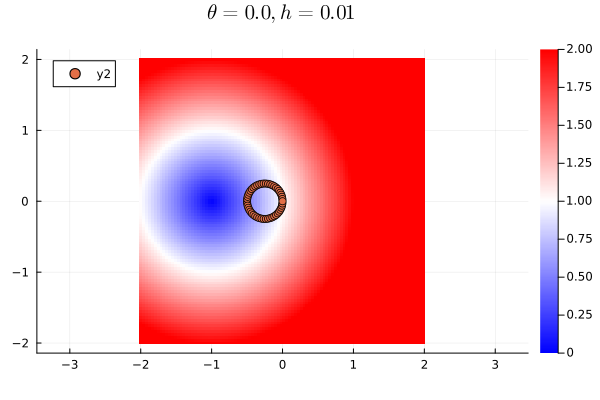

In [198]:
theta=0. # Change this if you like
h = .01 # Change this if you like
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(50, upwind=true)))
scatter!(real(ev), imag(ev))

* Let's try to eliminate the _dissipative_ error (called this because it causes the blob to spread) by changing the spatial discretization.
* The code below uses the same params, except a centered spatial discretization to compute derivatives.

  0.006273 seconds (12.72 k allocations: 8.628 MiB)


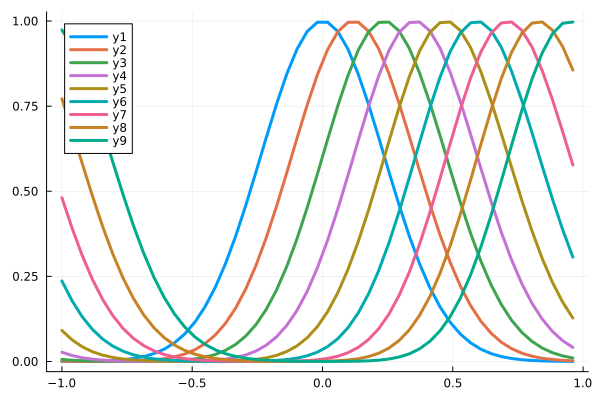

In [189]:
n = 51
A = advect_matrix(n, upwind=false)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.01, theta=0.5, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

* Nice! It looks like there is no dissipation anymore, and the shape of the blob is preserved. However, ...

In [199]:
eigvals(Matrix(advect_matrix(10, upwind=false)))

10-element Vector{ComplexF64}:
 -7.703719777548943e-34 - 4.755282581475769im
 -7.703719777548943e-34 + 4.755282581475769im
                    0.0 - 2.938926261462368im
                    0.0 - 2.9389262614623664im
                    0.0 - 1.2560848302247556e-16im
                    0.0 + 1.2560848302247556e-16im
                    0.0 + 2.9389262614623664im
                    0.0 + 2.938926261462368im
 2.0421828815638542e-88 - 4.7552825814757655im
 2.0421828815638542e-88 + 4.7552825814757655im

* The $\lambda$ values are clearly distributed differently, and in a way that restricts our choices for `theta`. Now we have to pick $\theta \geq 0.5$ for temporal stability. See the spectrum below.
* **Question**: Why would a choice of `theta` restricted to larger values be undesirable?

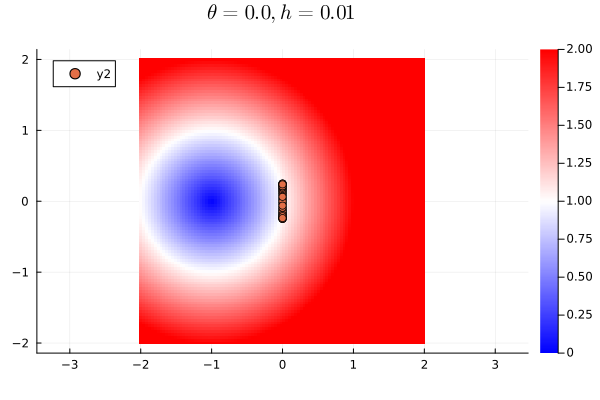

In [201]:
theta=0. # Change this if you like
h = .01 # Change this if you like
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(50, upwind=false)))
scatter!(real(ev), imag(ev))

* The bottom line is that both of these spatial (and temporal) discretizations are bad, but for different reasons.
* The dissipation issue comes from the leading order term in the truncation error of the spatial discretization methods: if the truncation error has leading even-order derivatives, the error is dissipative. 
* The upwind scheme is first-order, so the truncation error will have leading error terms going like $u_{xx}$: a dissipative term (recall the advection-diffusion equation having a term like that)!
* The centered scheme is second-order (therefore no dissipative errors), but leads to decreased temporal stability. 
* **Achieving both accuracy and stability is difficult, and requires care when picking both the spatial and temporal discretization**.

# Heat equation as linear ODE

* Let's now take a new example, $u_t = u_{xx}$, the heat equation. 
* This equation only has a "dissipative" term, and no advective term, so we expect the initial blob of $u$ to spread.
* The code below generates $f := u_{xx}$ with centered differences. 

In [61]:
function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -12.5     6.25     ⋅       ⋅      6.25
   6.25  -12.5     6.25     ⋅       ⋅ 
    ⋅      6.25  -12.5     6.25     ⋅ 
    ⋅       ⋅      6.25  -12.5     6.25
   6.25     ⋅       ⋅      6.25  -12.5

  0.011457 seconds (5.43 k allocations: 3.562 MiB, 69.62% gc time)


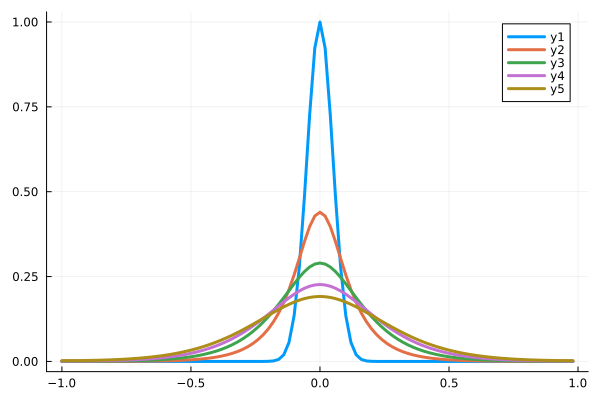

In [202]:
n = 100
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.01, theta=1, tfinal=.5); 
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

Check its spectrum. Note that I chose $\theta = 1$ deliberately for stability.

In [205]:
eigvals(Matrix(heat_matrix(8)))

8-element Vector{Float64}:
 -63.999999999999986
 -54.627416997969505
 -54.627416997969505
 -32.0
 -32.0
  -9.372583002030481
  -9.372583002030478
  -3.552713678800501e-15

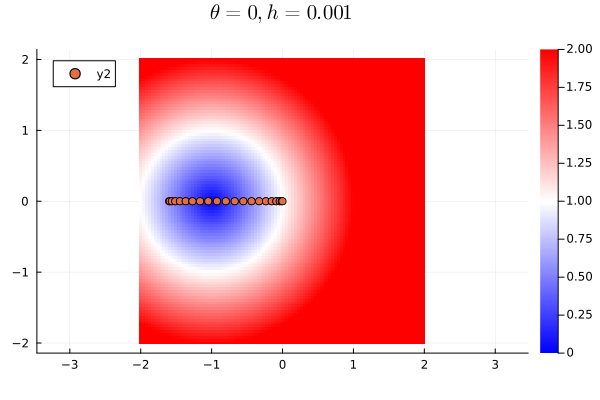

In [204]:
theta=0
h = .001
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*heat_matrix(40)))
scatter!(real(ev), imag(ev))

* Picking $\theta = 1$ turned out to be a good idea, as the $\lambda$ values stretch deep into the left half-plane for large $n$.

* **Question**: What would this mean for our choice of `h` if $\theta < 0.5$?

* Below we try `theta = 0.5`, which should be stable:

  0.001111 seconds (2.18 k allocations: 1.514 MiB)


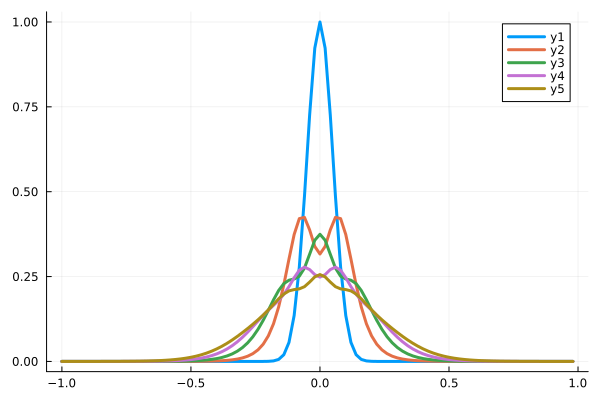

In [212]:
n = 100
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.005, theta=0.5, tfinal=.1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

* **Question**: What's wrong with this solution?

```{toggle}
Oscillations in the solution appear as time goes on. This is unphysical: why are there suddenly oscillations in temperature if we started with a Gaussian-shaped warm zone in the middle? 

The reason is similar to what caused the numerical dissipation in the advection equation. Here, the leading-order terms in the error manifest as _dispersion_ (usually in the form of travelling waves).

The difference between dissipation and dispersion is that dissipation means loss of energy, whereas dispersion happens when different Fourier components of a signal travel at different speeds, distorting the signal.
```

# Stability classes and the $\theta$ method

* We saw that the stability regions of $\theta$ methods were vastly different. 
* We distinguish between $A$- and $L$-stable methods based on their stability region.

## Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

## Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.